# TEMP: Temper with files

In [55]:
from helper.data_manager import load_training_data, save_training_data

#run_id = "cifar10_CNN_128_0.8073-1"
run_id = "cifar10_CNN_128_0.8699-1"
# 1. Load existing file
data = load_training_data(run_id)
print("Loaded keys:", list(data.keys()))

Loaded keys: ['embedding_drifts', 'grad_param_ratios', 'gradient_norms', 'll_flattened_weights_dir', 'max_gradients', 'model_info', 'scheduler_history', 'subset_embeddings', 'subset_labels', 'train_accuracies', 'train_config', 'train_losses', 'val_accuracies', 'val_losses']


In [56]:
print(data.get('train_config', ''))
print(data.get('model_info', ''))
print(data.get('ll_flattened_weights_dir', ''))

CNN|opt=AdamW|lr=0.001|wd=0.05|sam=False
CNN(conv_dims=[64, 128, 256], kernel_sizes=[5, 3, 3], hidden_dims=[256, 128], dropout=0.2, residual=True)
run-0001


In [49]:
# 2. Add or edit fields
data['train_config'] = "CNN|opt=AdamW|lr=0.001|wd=0.05|sam=False"
#data['model_info'] = "CNN(conv_dims=[64, 128, 256], kernel_sizes=[5, 3, 3], hidden_dims=[256, 128], dropout=0.2, residual=True)"
#data['ll_flattened_weights_dir'] = 'run-0004-CNN'

In [50]:
# 3. Save back
# run_id = f"{run_id}"
# save_training_data(run_id, data)
# print("Updated and saved!")

Save embedding_drifts#1
Save embedding_drifts#16
Save embedding_drifts#2
Save embedding_drifts#4
Save embedding_drifts#8
Save grad_param_ratios
Save gradient_norms
Save ll_flattened_weights_dir
Save max_gradients
Save model_info
Save scheduler_history
Save subset_embeddings
Save subset_labels
Save train_accuracies
Save train_config
Save train_losses
Save val_accuracies
Save val_losses


# Embedding Evolution

Different Training trajectories from Embedding perspective

In [103]:
dataset = "cifar10"

runs = [
    "run-0005-CNN_cifar10_128_0.8073",
    "cifar10_CNN_128_0.8699-1",
    "run-0006-CNN_cifar10_128_0.7348",
    "run-0007-CNN_cifar10_128_0.8476"
]

In [104]:
from helper.data_manager import load_training_data

results = []
for run in runs:
    result = load_training_data(run)
    result["embedding_drifts"] = {int(k): result["embedding_drifts"][k] for k in sorted(result["embedding_drifts"].keys(), key=int)}
    results.append(result)

## Recall: Trainings

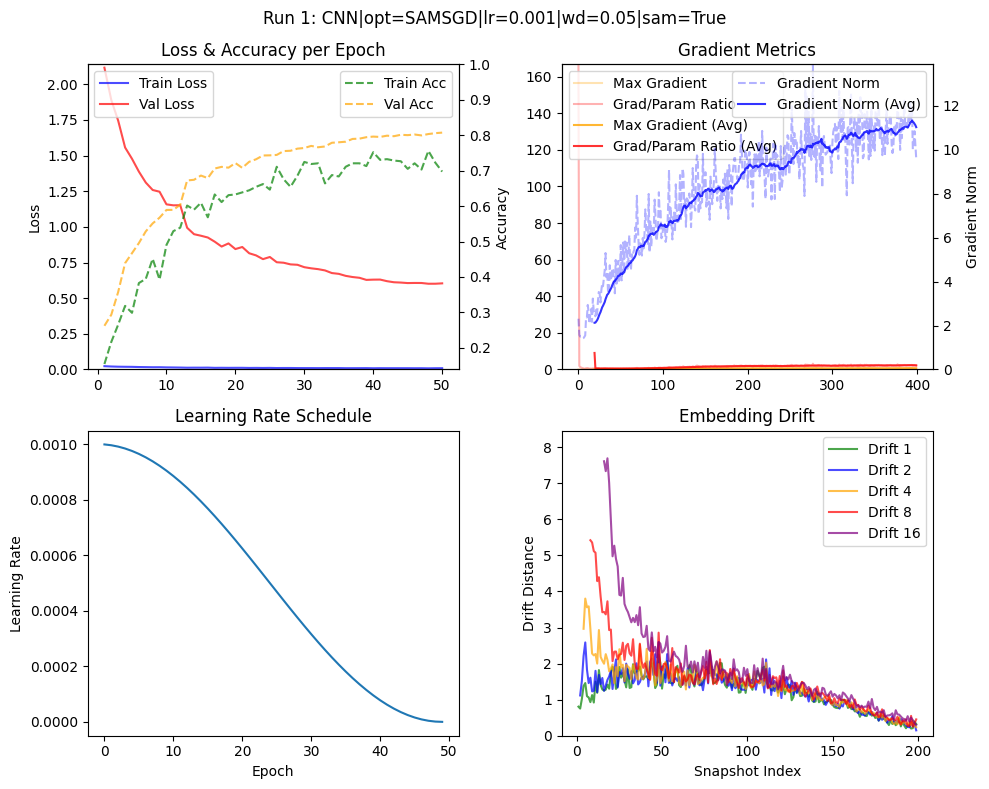

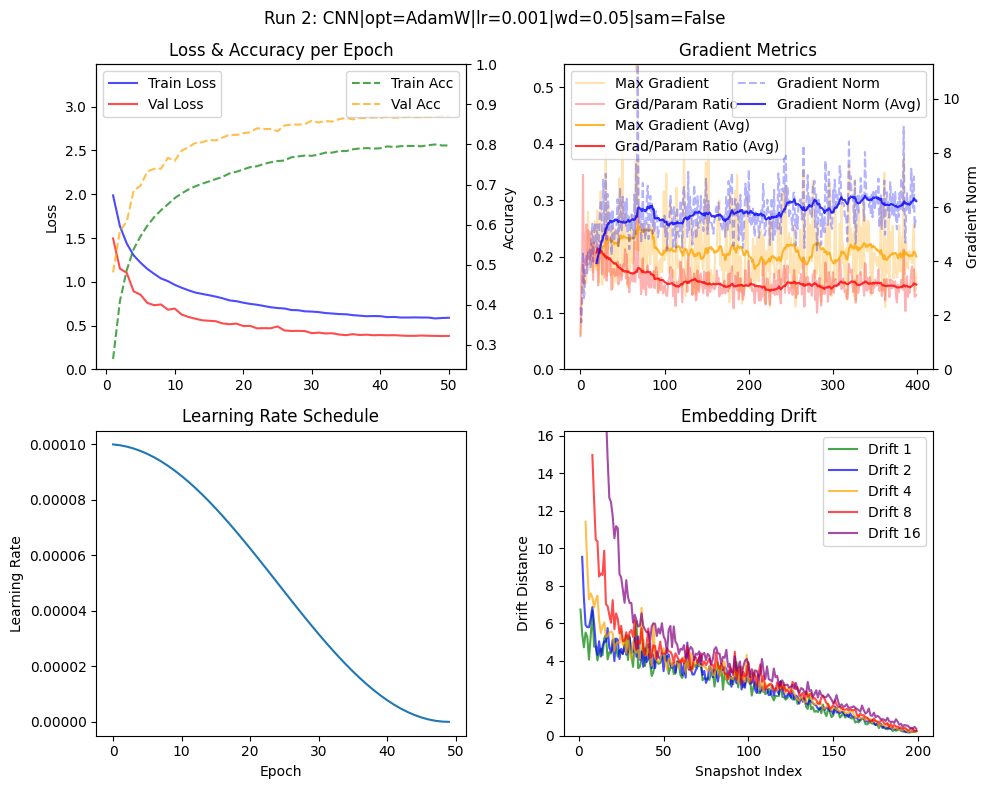

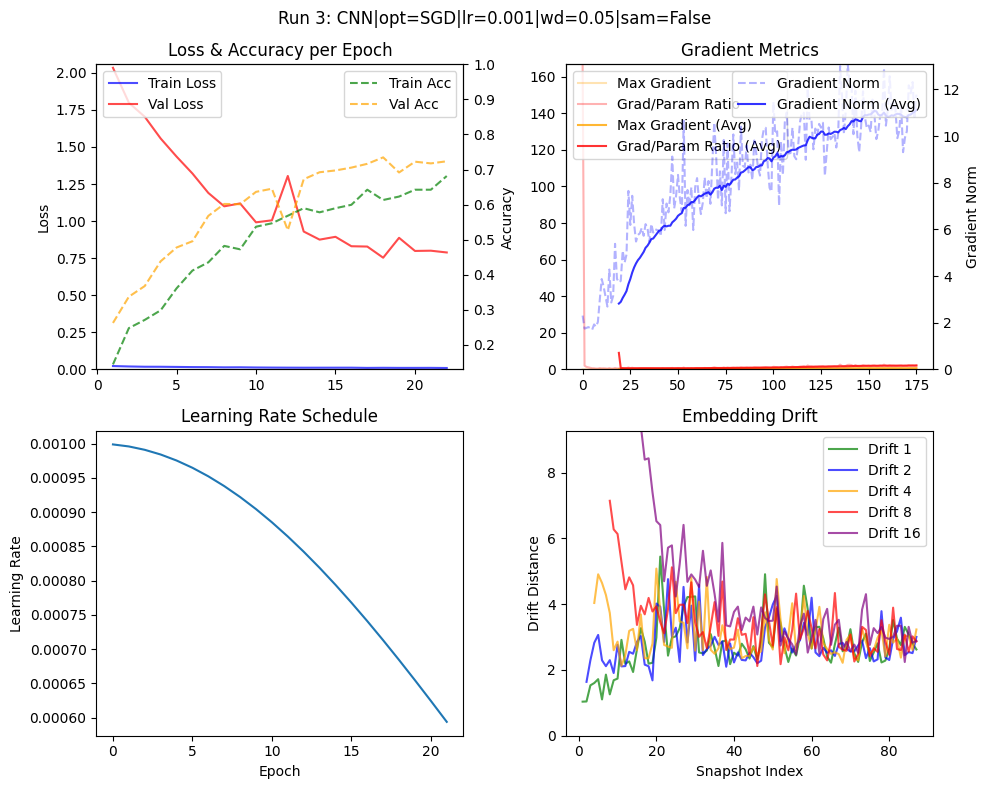

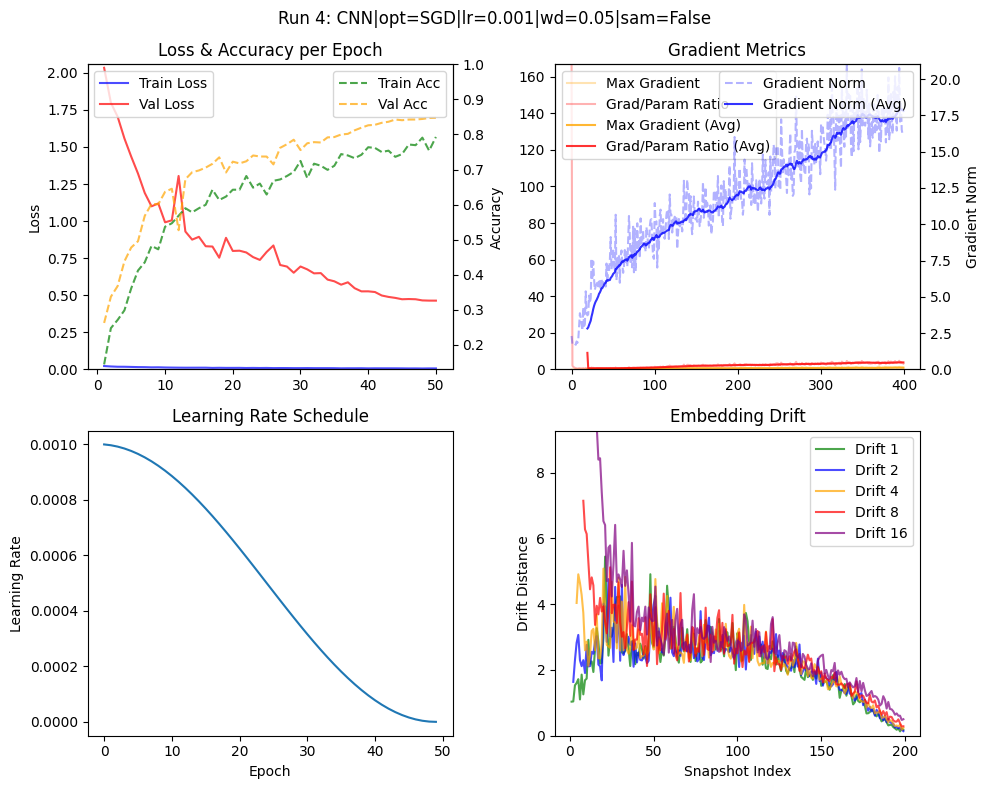

In [105]:
import matplotlib.pyplot as plt
from helper.plots import plot_loss_accuracy, plot_gradients, plot_embedding_drift, plot_scheduled_lr

for i, run_result in enumerate(results):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    train_config = run_result['train_config']
    fig.suptitle(f"Run {i+1}: {train_config}")

    epochs = len(run_result["train_losses"])
    plot_loss_accuracy(
        axs[0][0],
        epochs - 1,
        epochs,
        run_result["train_losses"],
        run_result["val_losses"],
        run_result["train_accuracies"],
        run_result["val_accuracies"]
    )

    plot_gradients(
        axs[0][1],
        range(len(run_result["gradient_norms"])),
        run_result["gradient_norms"],
        run_result["max_gradients"],
        run_result["grad_param_ratios"],
        20
    )

    if "scheduler_history" in run_result:
        plot_scheduled_lr(axs[1][0], run_result["scheduler_history"])
    else:
        axs[1][0].set_visible(False)

    plot_embedding_drift(axs[1][1], run_result["embedding_drifts"])

    plt.tight_layout()
    plt.show()

### 1. Snapshot distances in one epoch (colored by class)

In [11]:
import phate

In [12]:
import m_phate

In [94]:
single_result = results[0]

Calculating PHATE...
  Running PHATE on 1000 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.15 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.43 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.25 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.11 seconds.
Calculated PHATE in 2.68 seconds.


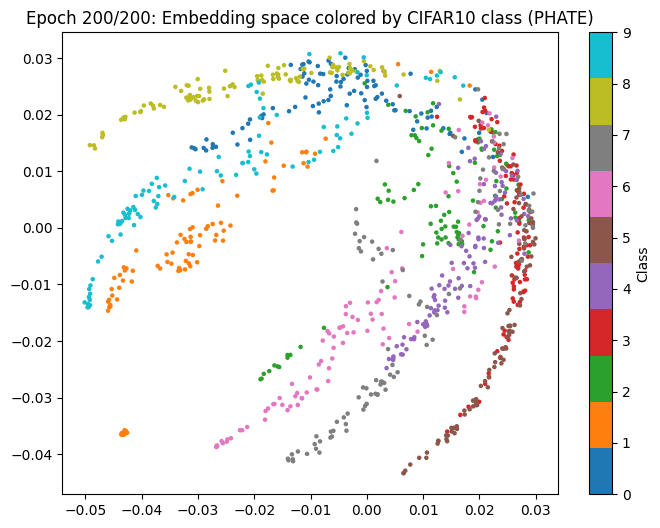

In [95]:
import phate
import matplotlib.pyplot as plt

# Choose Epoch e
total_epochs = len(single_result["subset_embeddings"])
e = 200

emb = single_result["subset_embeddings"][e - 1]
labels = single_result["subset_labels"][0] # [e-1 or [0] doesn't matter

# Apply PHATE
phate_op = phate.PHATE()
emb_phate = phate_op.fit_transform(emb)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(emb_phate[:, 0], emb_phate[:, 1], c=labels, cmap='tab10', s=5)
plt.title(f"Epoch {e}/{total_epochs}: Embedding space colored by CIFAR10 class (PHATE)")
plt.colorbar(label="Class")
plt.show()

# Takes ~ 5 seconds

### 2) Development of data points through epochs

In [96]:
import m_phate
import numpy as np
import matplotlib.pyplot as plt

# Collect embeddings: list of (samples x features)
emb_list = single_result["subset_embeddings"]
n_epochs = len(emb_list)
n_samples = emb_list[0].shape[0]
print(f"n_epochs: {n_epochs}")
print(f"n_samples: {n_samples}")

# Stack into (epochs, samples, features)
emb_tensor = np.stack(emb_list)  # shape: (epochs, samples, features)

# M-PHATE expects: (epochs, samples, features)
mphate_op = m_phate.M_PHATE()
mphate_emb = mphate_op.fit_transform(emb_tensor)  # shape: (epochs, samples, 2)

mphate_emb = mphate_emb.reshape(n_epochs, n_samples, -1)
# Takes ~10 min (scales on samples x epochs)

n_epochs: 200
n_samples: 1000
Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 5.03 seconds.
  Calculated multislice kernel in 40.56 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 111.69 seconds.
      Calculating KMeans...
      Calculated KMeans in 32.91 seconds.
    Calculated landmark operator in 164.68 seconds.
  Calculated graph and diffusion operator in 168.98 seconds.
  Running PHATE on precomputed affinity matrix with 200000 observations.
  Calculating optimal t...
    Automatically selected t = 63
  Calculated optimal t in 42.95 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 15.98 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 178.00 seconds.
Calculated M-PHATE in 446.72 seconds.


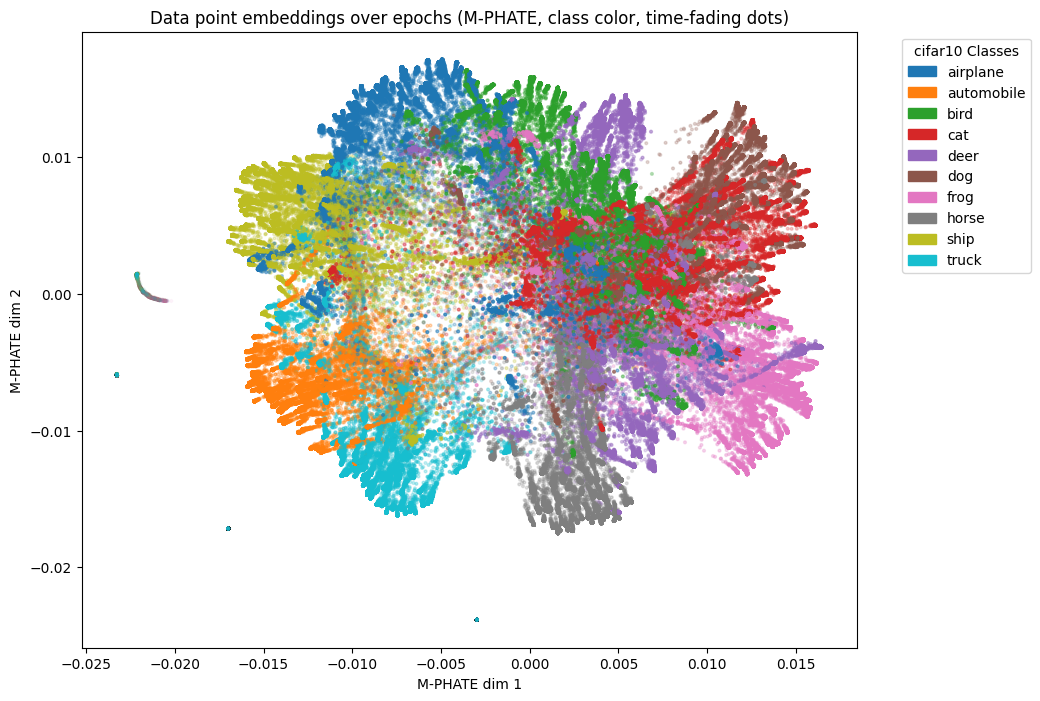

In [97]:
import matplotlib.patches as mpatches
from helper.vision_classification import get_text_labels

labels = single_result["subset_labels"][0]
class_names = get_text_labels(dataset)

min_alpha = 0.05
max_alpha = 0.9

plt.figure(figsize=(10, 8))

for epoch in range(n_epochs):
    alpha = min_alpha + (max_alpha - min_alpha) * (epoch / (n_epochs - 1))
    plt.scatter(
        mphate_emb[epoch, :, 0],
        mphate_emb[epoch, :, 1],
        c=[plt.cm.tab10(l) for l in labels],
        alpha=alpha,
        s=4
    )

plt.title("Data point embeddings over epochs (M-PHATE, class color, time-fading dots)")
plt.xlabel("M-PHATE dim 1")
plt.ylabel("M-PHATE dim 2")

# --- Add legend for classes ---
handles = [mpatches.Patch(color=plt.cm.tab10(i), label=class_names[i]) for i in range(10)]
plt.legend(handles=handles, title=f"{dataset} Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

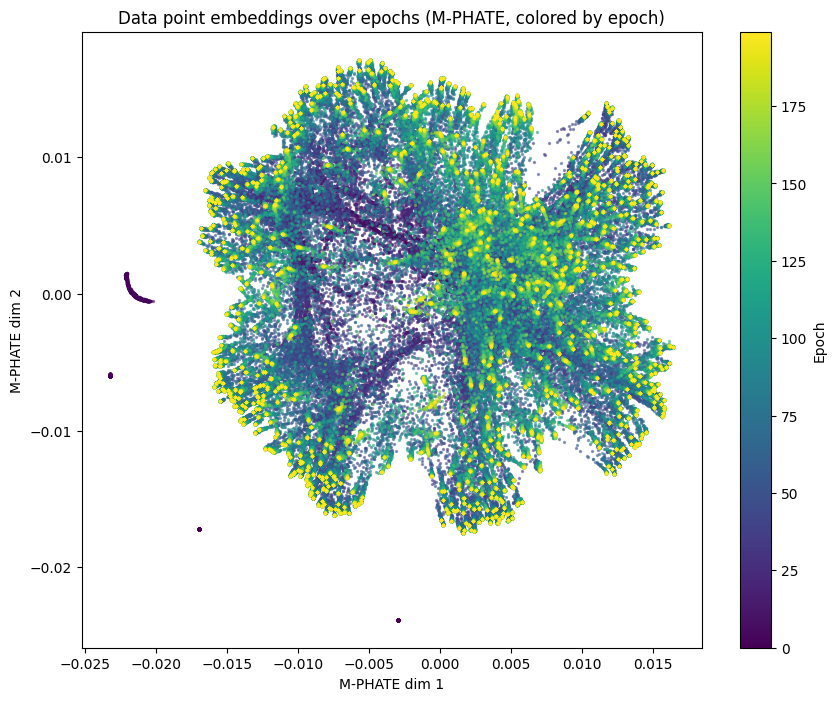

In [98]:
cmap = plt.cm.viridis  # or any other
norm = plt.Normalize(vmin=0, vmax=n_epochs - 1)

plt.figure(figsize=(10, 8))
ax = plt.gca()

for epoch in range(n_epochs):
    ax.scatter(
        mphate_emb[epoch, :, 0],
        mphate_emb[epoch, :, 1],
        c=[cmap(norm(epoch))],
        label=f"Epoch {epoch}" if epoch in [0, n_epochs - 1] else "",
        s=2,
        alpha=0.5
    )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax, label="Epoch")

plt.title("Data point embeddings over epochs (M-PHATE, colored by epoch)")
plt.xlabel("M-PHATE dim 1")
plt.ylabel("M-PHATE dim 2")
plt.show()

In [99]:
class_cmap = plt.cm.tab10
epoch_cmap = plt.cm.viridis

# ---- Define your epoch range ----
start_epoch = 50
end_epoch = 200

# ---- Slice data ----
selected_emb = mphate_emb[start_epoch:end_epoch]
selected_epochs = end_epoch - start_epoch
selected_norm = plt.Normalize(vmin=start_epoch, vmax=end_epoch - 1)

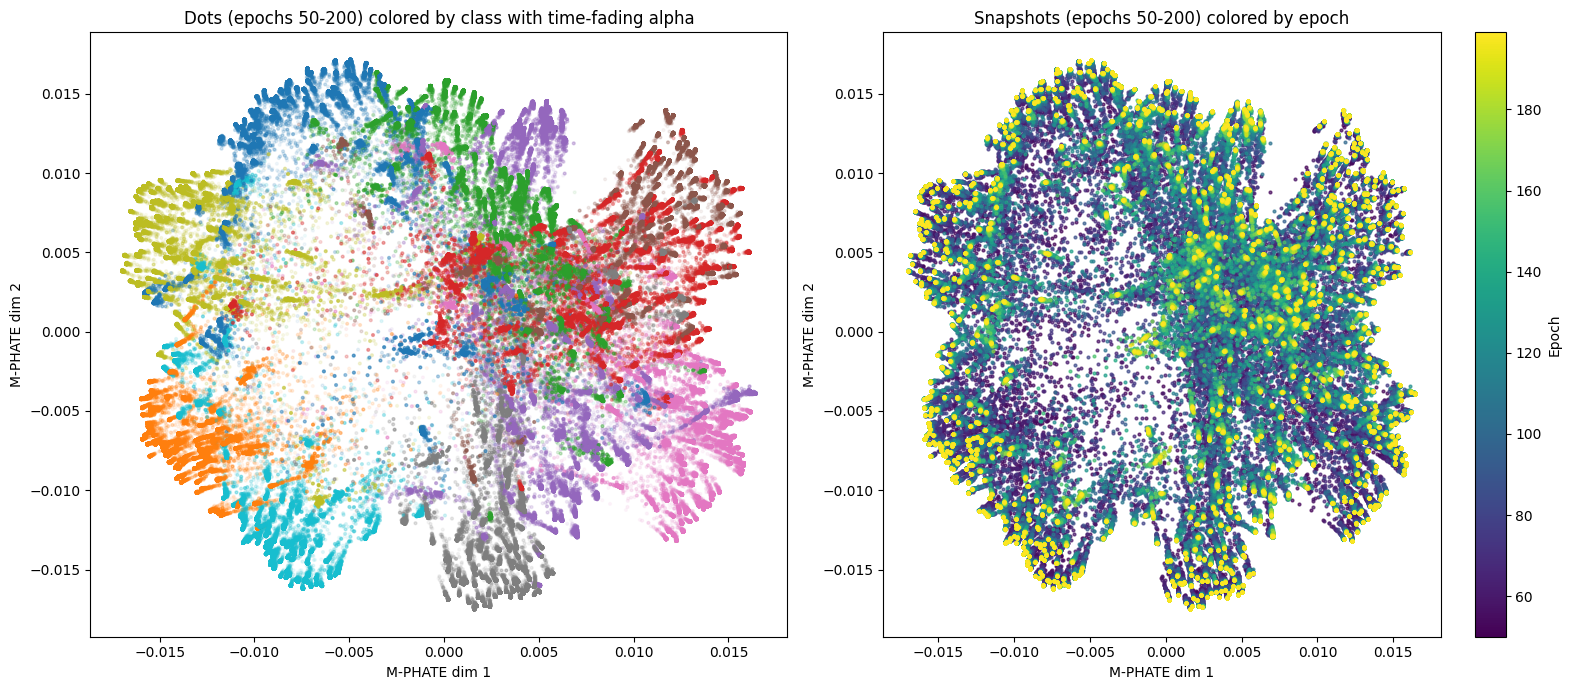

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- Left: Dots per sample per epoch, colored by class, fading with time ---
for idx, epoch in enumerate(range(start_epoch, end_epoch)):
    # Compute fading alpha over time
    alpha = min_alpha + (max_alpha - min_alpha) * ((epoch - start_epoch) / (end_epoch - start_epoch - 1))
    axs[0].scatter(
        selected_emb[idx, :, 0],
        selected_emb[idx, :, 1],
        c=[class_cmap(labels[i]) for i in range(n_samples)],
        alpha=alpha,
        s=4
    )

axs[0].set_title(f"Dots (epochs {start_epoch}-{end_epoch}) colored by class with time-fading alpha")
axs[0].set_xlabel("M-PHATE dim 1")
axs[0].set_ylabel("M-PHATE dim 2")

# --- Right: Dots colored by epoch ---
for idx, epoch in enumerate(range(start_epoch, end_epoch)):
    axs[1].scatter(
        selected_emb[idx, :, 0],
        selected_emb[idx, :, 1],
        c=[epoch_cmap(selected_norm(epoch))],
        s=4,
        alpha=0.7
    )

sm = plt.cm.ScalarMappable(cmap=epoch_cmap, norm=selected_norm)
fig.colorbar(sm, ax=axs[1], label="Epoch")

axs[1].set_title(f"Snapshots (epochs {start_epoch}-{end_epoch}) colored by epoch")
axs[1].set_xlabel("M-PHATE dim 1")
axs[1].set_ylabel("M-PHATE dim 2")

plt.tight_layout()
plt.show()

### 3) Development of class-similarity through epochs

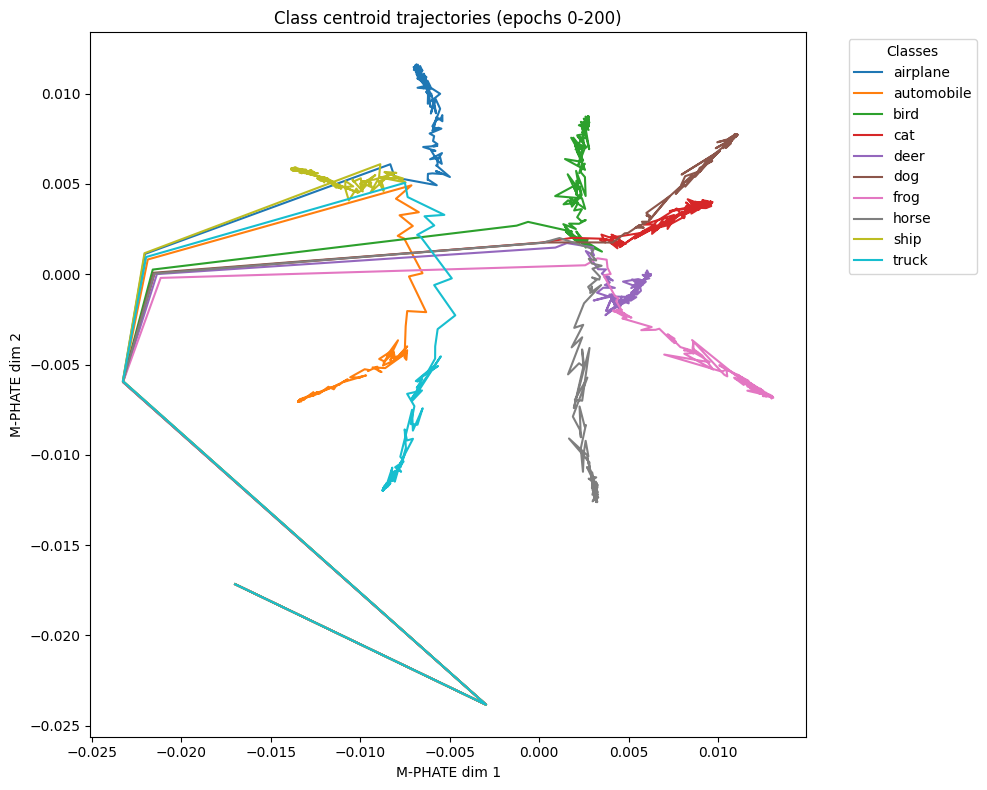

In [101]:
# ---- Define your epoch range ----
start_epoch = 0
end_epoch = 200

# ---- Slice data ----
selected_emb = mphate_emb[start_epoch:end_epoch]
selected_epochs = end_epoch - start_epoch
selected_norm = plt.Normalize(vmin=start_epoch, vmax=end_epoch - 1)


unique_classes = np.unique(labels)
n_classes = len(unique_classes)

# --- Compute class centroids over time ---
class_centroids = []
for idx in range(selected_emb.shape[0]):  # over selected epochs
    epoch_emb = selected_emb[idx]
    centroids = []
    for c in unique_classes:
        class_mask = (labels == c)
        centroids.append(epoch_emb[class_mask].mean(axis=0))
    class_centroids.append(np.stack(centroids))

class_centroids = np.stack(class_centroids)  # shape: (epochs, classes, dims)

# --- Plot centroids as lines per class ---
plt.figure(figsize=(10, 8))
for c in range(n_classes):
    plt.plot(
        class_centroids[:, c, 0],
        class_centroids[:, c, 1],
        color=class_cmap(c),
        label=class_names[c]
    )

plt.title(f"Class centroid trajectories (epochs {start_epoch}-{end_epoch})")
plt.xlabel("M-PHATE dim 1")
plt.ylabel("M-PHATE dim 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4) Development of whole model-embeddings across runs

In [52]:
# --- 1) Gather all embeddings ---
all_runs_embs = []
run_epoch_counts = []

for run in results:
    n_epochs = len(run["subset_embeddings"])
    print(f"Run with {n_epochs} epochs")
    emb_list = run["subset_embeddings"]
    emb_tensor = np.stack(emb_list)  # (epochs, samples, features)
    all_runs_embs.append(emb_tensor)
    run_epoch_counts.append(emb_tensor.shape[0])

# Concatenate over epochs from all runs
combined_emb = np.concatenate(all_runs_embs, axis=0)  # (total_epochs_all_runs, samples, features)

print("Combined shape:", combined_emb.shape)

Combined shape: (488, 1000, 128)


In [115]:
# --- 1a) With subsampling per class ---
all_runs_embs_subsampled = []
run_epoch_counts = []

for run in results:
    emb_list = run["subset_embeddings"]
    n_epochs = len(run["subset_embeddings"])
    print(f"Run with {n_epochs} epochs")
    labels_full = run["subset_labels"][0]
    unique_classes = np.unique(labels_full)
    
    compressed_epochs = []
    
    for epoch_emb in emb_list:
        class_means = []
        for c in unique_classes:
            class_mask = (labels_full == c)
            mean_vec = epoch_emb[class_mask].mean(axis=0)
            class_means.append(mean_vec)
        compressed_epochs.append(np.stack(class_means))
    
    compressed_tensor = np.stack(compressed_epochs)  # (epochs, 10, features)
    run_epoch_counts.append(compressed_tensor.shape[0])
    all_runs_embs_subsampled.append(compressed_tensor)
    
combined_emb = np.concatenate(all_runs_embs_subsampled, axis=0)
print("Combined shape:", combined_emb.shape)

Run with 200 epochs
Run with 200 epochs
Run with 88 epochs
Run with 200 epochs
Combined shape: (688, 10, 128)


In [107]:
# 2) Apply M-PHATE once
mphate_op = m_phate.M_PHATE()
mphate_emb = mphate_op.fit_transform(combined_emb)
total_epochs = combined_emb.shape[0]
n_samples = combined_emb.shape[1]
mphate_emb = mphate_emb.reshape(total_epochs, n_samples, -1)

# Takes ~3-4 Minutes (unsubsampled) -> 1 Min subsampled

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.19 seconds.
  Calculated multislice kernel in 10.39 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 1.55 seconds.
      Calculating KMeans...
      Calculated KMeans in 7.61 seconds.
    Calculated landmark operator in 11.47 seconds.
  Calculated graph and diffusion operator in 11.65 seconds.
  Running PHATE on precomputed affinity matrix with 6880 observations.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 28.97 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 4.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 94.74 seconds.
Calculated M-PHATE in 150.29 seconds.


In [117]:
split_mphate = []
cursor = 0

for n_epochs in run_epoch_counts:
    split_mphate.append(mphate_emb[cursor:cursor + n_epochs])
    cursor += n_epochs

In [118]:
all_run_means = []

for run_emb in split_mphate:
    mean_traj = run_emb.mean(axis=1)  # (epochs, 2)
    all_run_means.append(mean_traj)

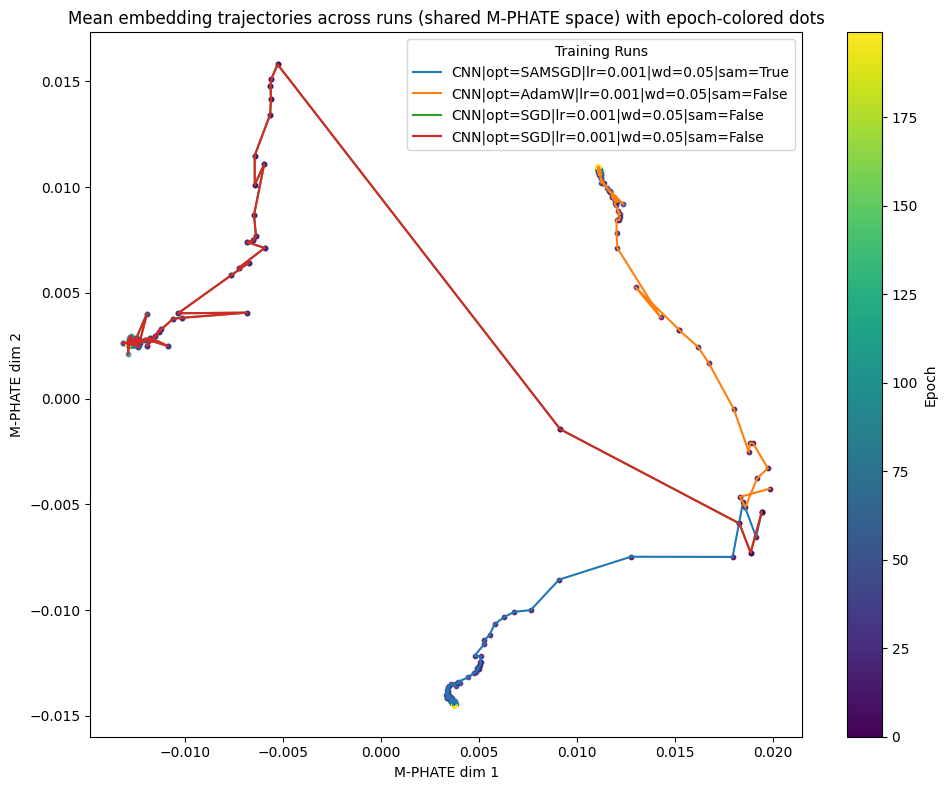

In [130]:
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=max(len(traj) for traj in all_run_means) - 1)

plt.figure(figsize=(10, 8))
ax = plt.gca()

for idx, traj in enumerate(all_run_means):
    n_epochs = traj.shape[0]
    
    # Plot trajectory line
    ax.plot(
        traj[:, 0], traj[:, 1],
        label=results[idx]["train_config"]
    )
    
    # Add dots per epoch, colored by epoch
    for epoch in range(n_epochs):
        ax.scatter(
            traj[epoch, 0], traj[epoch, 1],
            color=cmap(norm(epoch)),
            s=10,
            alpha=0.8
        )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax, label="Epoch")

ax.set_title("Mean embedding trajectories across runs (shared M-PHATE space) with epoch-colored dots")
ax.set_xlabel("M-PHATE dim 1")
ax.set_ylabel("M-PHATE dim 2")
ax.legend(title="Training Runs")
plt.tight_layout()
plt.show()